# Evaluation

In [1]:
# from model_data import CuDNNLSTM , LSTMDataset

In [2]:
from torch.utils.data import DataLoader # type: ignore
import torch.optim as optim # type: ignore
from torch.optim.lr_scheduler import ReduceLROnPlateau # type: ignore
from torch import nn # type: ignore

from hython.models.cudnnLSTM import CuDNNLSTM
from hython.datasets import LSTMDataset
from hython.sampler import *
from hython.normalizer import Normalizer
from hython.trainer import *
from hython.io import read_from_zarr
from hython.utils import missing_location_idx, set_seed, prepare_for_plotting
from hython.evaluator import predict
from hython.trainer import train_val
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
from hython.viz import map_kge, map_bias, map_correlation, map_rmse, map_at_timesteps, ts_compare, plot_sampler, ts_plot, map_points

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Settings

In [3]:
EXP_METADATA = {
    "vwc_2":[ "thetaS", "thetaR"],
    "actevap_2":["Swood", "Sl"] ,
    "vwc_4":[ "thetaS", "thetaR", "KsatVer", "SoilThickness"],
    "vwc_4_1":[ "thetaS", "thetaR", "KsatVer", "SoilThickness"], # train more data and longer epochs
    "vwc_4_2":[ "thetaS", "thetaR", "KsatVer", "SoilThickness"], # train with deeper layers,
    "vwc_4_3":[ "thetaS", "thetaR", "KsatVer", "SoilThickness"], # train with deeper smaller kernel 3 x 3
    "vwc_4_4":[ "thetaS", "thetaR", "KsatVer", "SoilThickness"], # simple LSTM
    "vwc_actevap":['thetaS', 'thetaR', 'SoilThickness','RootingDepth', 'Swood','KsatVer', 'Sl', 'f', 'Kext', 'PathFrac', 'WaterFrac'],
    "sensitivity_lstm":[ "thetaS", "thetaR", "KsatVer", "SoilThickness"]
}

In [8]:
EXPERIMENT  = "vwc_actevap"

SURROGATE_INPUT = "https://eurac-eo.s3.amazonaws.com/INTERTWIN/SURROGATE_INPUT/adg1km_eobs_preprocessed.zarr/"
COORDINATES_INPUT = "https://eurac-eo.s3.amazonaws.com/INTERTWIN/SURROGATE_INPUT/adg1km_eobs_original.zarr/"

SURROGATE_MODEL_OUTPUT = f"/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/{EXPERIMENT}.pt"
TMP_STATS = "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats"

# === FILTER ==============================================================

# train/test temporal range
train_temporal_range = slice("2016-01-01","2018-12-31")
test_temporal_range = slice("2019-01-01", "2020-12-31")

# variables
dynamic_names = ["precip", "pet", "temp"] 
static_names = EXP_METADATA[EXPERIMENT]
target_names = ["vwc","actevap"] #"q_land_toriver", "ssf_toriver","runoff_river"] #, "runoff_land", "runoff_river", "snow", "snowwater"]#, "snow", "snowwater"]

# === MASK ========================================================================================

mask_names = ["mask_missing", "mask_lake"] # names depends on preprocessing application

# === DATASET ========================================================================================

DATASET = "LSTMDataset"

# == MODEL  ========================================================================================

HIDDEN_SIZE = 64
DYNAMIC_INPUT_SIZE = len(dynamic_names)
STATIC_INPUT_SIZE = len(static_names)
OUTPUT_SIZE = len(target_names)

TARGET_WEIGHTS = {t:1/len(target_names) for t in target_names}


# === SAMPLER/TRAINER ===================================================================================

EPOCHS = 40
BATCH = 256
SEED = 42


TEMPORAL_SUBSAMPLING = True
TEMPORAL_SUBSET = [150, 150] 
SEQ_LENGTH = 120


assert sum(v for v in TARGET_WEIGHTS.values()) == 1, "check target weights"
TARGET_INITIALS = "".join([i[0].capitalize() for i in target_names])

In [9]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"


In [10]:
Xd = (
    read_from_zarr(url=SURROGATE_INPUT, group="xd", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .xd.sel(feat=dynamic_names)
)
Xs = read_from_zarr(url=SURROGATE_INPUT, group="xs", multi_index="gridcell").xs.sel(
    feat=static_names
)
Y = (
    read_from_zarr(url=SURROGATE_INPUT, group="y", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .y.sel(feat=target_names)
)

SHAPE = Xd.attrs["shape"]


# === READ TEST ===================================================================

Y_test = (
    read_from_zarr(url=SURROGATE_INPUT, group="y", multi_index="gridcell")
    .sel(time=test_temporal_range)
    .y.sel(feat=target_names)
)
Xd_test = (
    read_from_zarr(url=SURROGATE_INPUT, group="xd", multi_index="gridcell")
    .sel(time=test_temporal_range)
    .xd.sel(feat=dynamic_names)
)

In [11]:
# === MASK ============================================================= 
masks = (
    read_from_zarr(url=SURROGATE_INPUT, group="mask")
    .mask.sel(mask_layer=mask_names)
    .any(dim="mask_layer")
)

In [12]:
# === NORMALIZE ============================================================= 

normalizer_dynamic = Normalizer(method="standardize",
                                type="spacetime", axis_order="NTC",
                                #save_stats=f"{TMP_STATS}/{EXPERIMENT}_xd.npy"
                               )
normalizer_static = Normalizer(method="standardize",
                               type="space", axis_order="NTC",
                               #save_stats=f"{TMP_STATS}/{EXPERIMENT}_xs.npy"
                              )
normalizer_target = Normalizer(method="standardize", type="spacetime",
                               axis_order="NTC"
                               #save_stats=f"{TMP_STATS}/{EXPERIMENT}_y.npy"
)

In [13]:
# normalizer_dynamic.read_stats(f"{TMP_STATS}/{EXPERIMENT}_xd.npy")
# normalizer_static.read_stats(f"{TMP_STATS}/{EXPERIMENT}_xs.npy")
# normalizer_target.read_stats(f"{TMP_STATS}/{EXPERIMENT}_y.npy")


# Xd_test = normalizer_dynamic.normalize(Xd_test)
# Xs = normalizer_static.normalize(Xs)
# Y_test = normalizer_target.normalize(Y_test)

In [19]:
# import numpy as np
# def compute_with_gradients(Xd, Xs, Y_test, model, batch_size, device):
#     print(Xd.shape)
#     print(Xs.shape)
#     print(Y_test.shape)
    
#     Xd = torch.tensor(Xd).float()
#     Xs = torch.tensor(Xs).float()
#     Y_test = torch.tensor(Y_test).float()
    
#     Xd = torch.nan_to_num(Xd, nan = 0.0)
#     Xs = torch.nan_to_num(Xs, nan = 0.0)


#     model = model.to(device)
#     model.train()
#     results = torch.zeros_like(Y_test)
#     model.eval()  
#     arr = []
#     Xd.requires_grad_(True)
#     Xs.requires_grad_(True)


#     grads = []
#     for i in range(0, Xd.shape[0], batch_size):
#         # print(i//256)
#         d = torch.Tensor(Xd[i : (i + batch_size)]).to(device)
#         s = torch.Tensor(Xs[i : (i + batch_size)]).to(device)
#         s = s.unsqueeze(1).repeat(1, d.size(1), 1)
        


#         x_ds_batch = torch.cat((d, s), dim=-1)
        
#         l1_batch = model.fc0(x_ds_batch)
#         lstm_out = model.lstm(l1_batch)
#         outputs = model.fc1(lstm_out[0])
        

    
        
#         if i/256.0 == 156.0:
#             results[i:i+204,:,:] = outputs
#         else:
#             results[i:i+batch_size,:,:] = outputs


#     results_num = torch.nan_to_num(results,nan =0.0)

#     Y_test_num = torch.nan_to_num(Y_test,nan =0.0)
#     virtual_loss = (results_num - Y_test_num).mean(axis = 1)
#     fianl_loss = virtual_loss.sum()  # 创建一个简单的虚拟损失
#     fianl_loss.backward(retain_graph=True)
#     aaa = Xd.grad
#     bbb = Xs.grad
    
#     return results, aaa,bbb

In [15]:
# Static to dynamic
Xs2 = Xs.expand_dims(dim={"time":Xd_test.time}, axis=1)

In [16]:
test_dataset = LSTMDataset(
        Xd_test,
        Y_test,
        Xs2,
        original_domain_shape=SHAPE,
        mask=masks,
        downsampler=None,
        normalizer_dynamic=normalizer_dynamic,
        normalizer_static=normalizer_static,
        normalizer_target=normalizer_target,
        
)

In [17]:
test_sampler_builder = SamplerBuilder(
    test_dataset,
    sampling="sequential", 
    processing="single-gpu")

test_sampler = test_sampler_builder.get_sampler()
test_loader = DataLoader(test_dataset, batch_size=BATCH , sampler=test_sampler)

In [18]:

def compute_with_gradients_sensitivity(dataloader, model,device):
    
    model = model.to(device)
    model.train()
    results = torch.zeros_like(dataloader.dataset.y[:len(dataloader)*dataloader.batch_size,:,:])

    dataloader.dataset.xd.requires_grad_(True)
    dataloader.dataset.xs.requires_grad_(True)

    i = 0
    for d, s, y in dataloader:
        #s = s.unsqueeze(1).repeat(1, d.size(1), 1)
        x_ds_batch = torch.cat((d, s), dim=-1).to(device)

        l1_batch = model.fc0(x_ds_batch)
        lstm_out = model.lstm(l1_batch)
        outputs = model.fc1(lstm_out[0])

        
        results[(i*outputs.shape[0]):(i*outputs.shape[0]+outputs.shape[0]),:,:] = outputs

        i += 1

    results_num = torch.nan_to_num(results,nan =0.0)
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

    results_num[:,:,0].backward(torch.ones_like(results_num[:,:,0])) # 0 soil moisture, 1 actevap
    aaa = dataloader.dataset.xd.grad
    bbb = dataloader.dataset.xs.grad
    
    return results, aaa,bbb

In [21]:
# ==== MODEL VAE ============================================================================

model = CuDNNLSTM(
                  hidden_size=HIDDEN_SIZE, 
                  dynamic_input_size=DYNAMIC_INPUT_SIZE,
                  static_input_size=STATIC_INPUT_SIZE, 
                  output_size=OUTPUT_SIZE
)


model.to(device)

# model load precomputed weights 
model.load_state_dict(torch.load(SURROGATE_MODEL_OUTPUT)) # ,map_location=torch.device('cpu')

<All keys matched successfully>

In [22]:
# === Calculate input gradient with related to Actevap.  =============================================================================
results, Xd_grad, Xs_grad = compute_with_gradients_sensitivity(test_loader, model, device)

In [23]:
# === sensitivity map of dynamic parameters with related to the input
# Xd_gradient * Xd_values =============================================================================

sensitivity = Xd_grad*Xd_test.values


In [180]:
# === sensitivity map of static parameters with related to the input
sensitivity_static = Xs_grad*Xs.values[:,None]

In [25]:
sensitivity.shape, Xd_grad.shape

(torch.Size([40140, 731, 3]), torch.Size([40140, 731, 3]))

In [26]:
# === Plotting parameters =============================================================================
coords = read_from_zarr(COORDINATES_INPUT, group="y").sel(time=test_temporal_range).isel(time=1).coords

In [27]:
lat, lon, time = len(masks.lat),len(masks.lon), Xd_test.shape[1]
lat, lon, time

(180, 223, 731)

In [179]:
dynamic_names


['precip', 'pet', 'temp']

In [155]:
grad, sens = prepare_for_plotting(
                                            Xd_grad[:,:,[2]],
                                            sensitivity[:,:,[2]], 
                                            shape = (*SHAPE, time), 
                                            coords  = coords)

In [31]:
#y_pred_plot.isel(time=0).where(y_pred_plot.isel(time=0) != 0).plot(vmin=-200, vmax=200)

# ts_compare(Xd_test.unstack().sel(feat="pet"),Xd_test.unstack().sel(feat="pet"), 
#                        label_1="grad", label_2 = "sensitivity", lat = [46.5], lon = [11.4])

In [175]:
grad["time"] = Xd_test.time
sens["time"] = Xd_test.time



In [157]:
ds = Xd_test.unstack().to_dataset("feat")

In [158]:
mask = (ds.sel(lat=46.5, lon=11.4, method="nearest") > 0).pet

In [159]:
mask = (ds < 0).temp

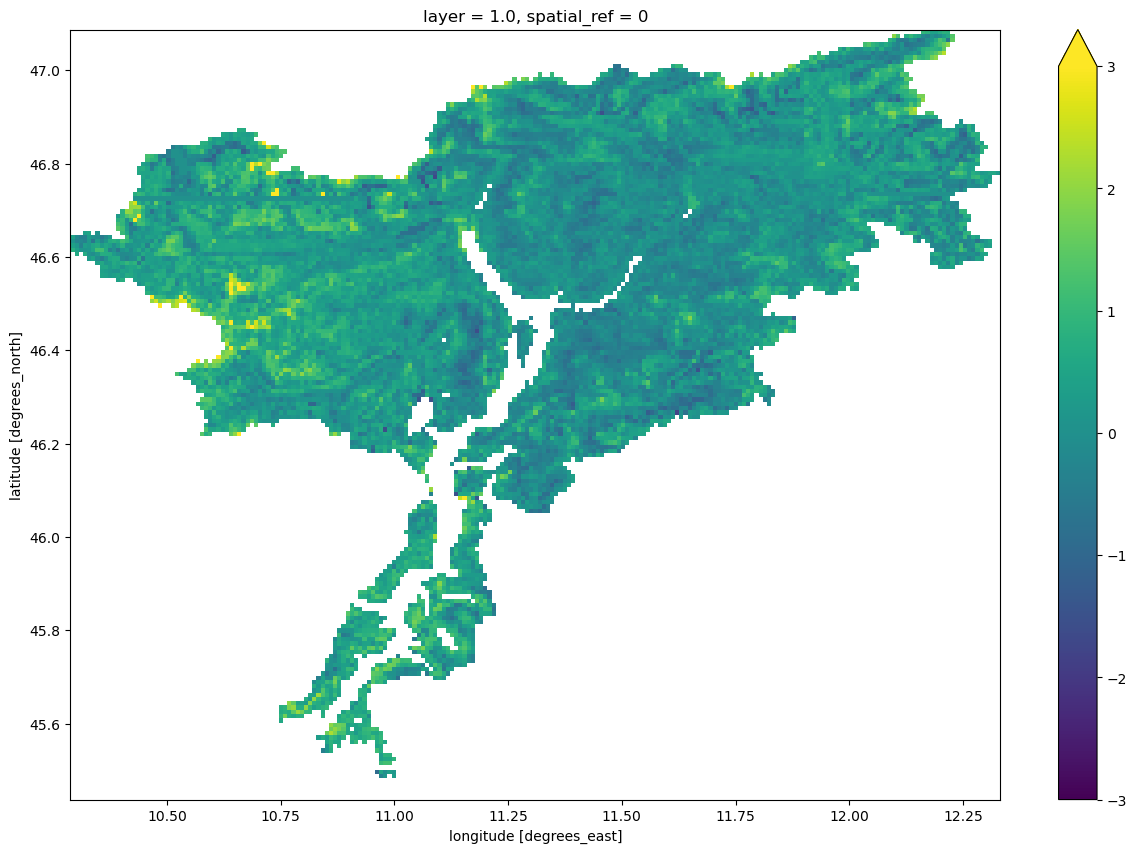

In [138]:
mask = (ds < 0).temp
sens.where(mask).mean("time").plot(figsize=(15,10), vmin=-3,vmax=3)

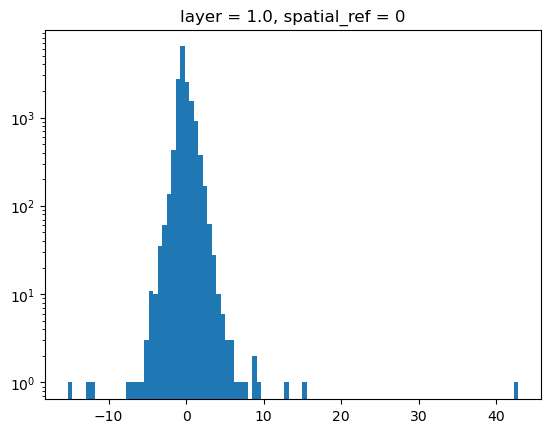

In [160]:
sens.mean("time").plot.hist(bins=100);
plt.yscale("log")

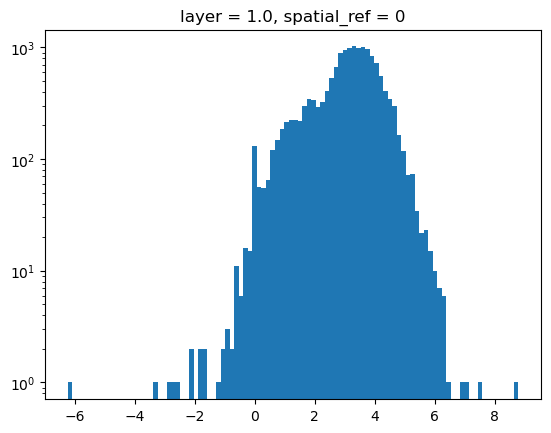

In [151]:
sens.mean("time").plot.hist(bins=100);
plt.yscale("log")

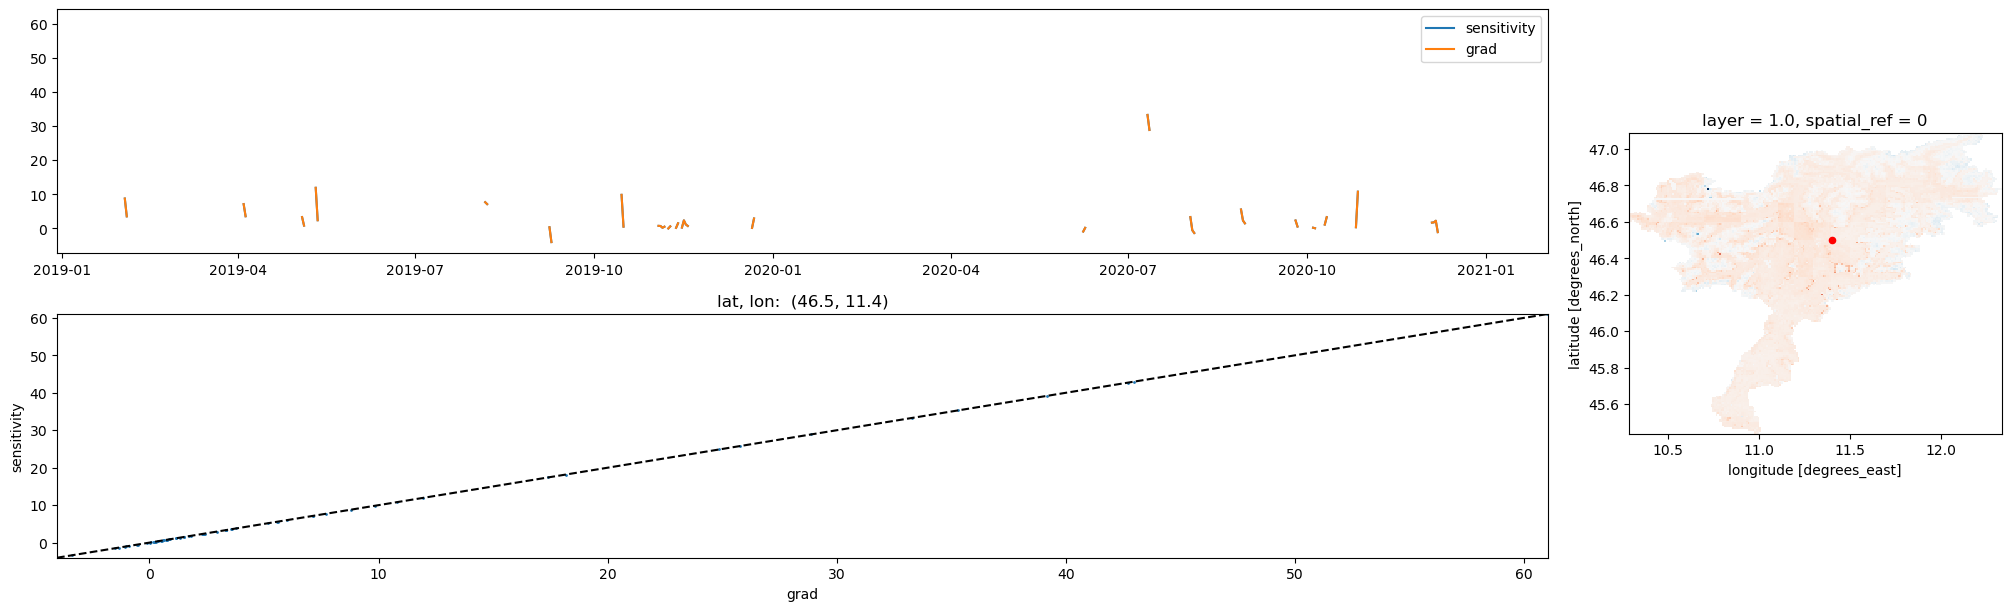

In [105]:
ts_compare(sens.where(mask),  sens.where(mask), label_1="grad", label_2 = "sensitivity", lat = [46.5], lon = [11.4]   )

In [182]:
static_names,Xs_grad.shape

(['thetaS',
  'thetaR',
  'SoilThickness',
  'RootingDepth',
  'Swood',
  'KsatVer',
  'Sl',
  'f',
  'Kext',
  'PathFrac',
  'WaterFrac'],
 torch.Size([40140, 731, 11]))

In [186]:
grad_static, sens_static = prepare_for_plotting(
                                            Xs_grad[:,:, [5] ], 
                                            sensitivity_static[:,:, [5] ],  
                                            shape = (*SHAPE, time), 
                                            coords  = coords)


In [187]:
grad_static["time"] = Xd_test.time
sens_static["time"] = Xd_test.time

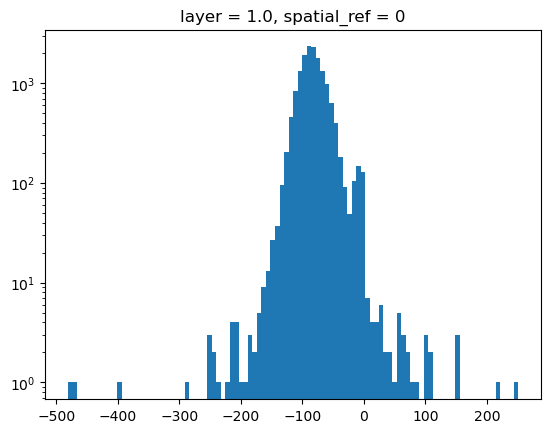

In [188]:
sens_static.mean("time").plot.hist(bins=100);
plt.yscale("log")

In [189]:
ds_static = Xs2.unstack().to_dataset("feat")

In [200]:
ds_static.KsatVer.min()

<xarray.DataArray 'KsatVer' ()> Size: 8B
array(44.97682571)
Coordinates:
    layer    int64 8B 1

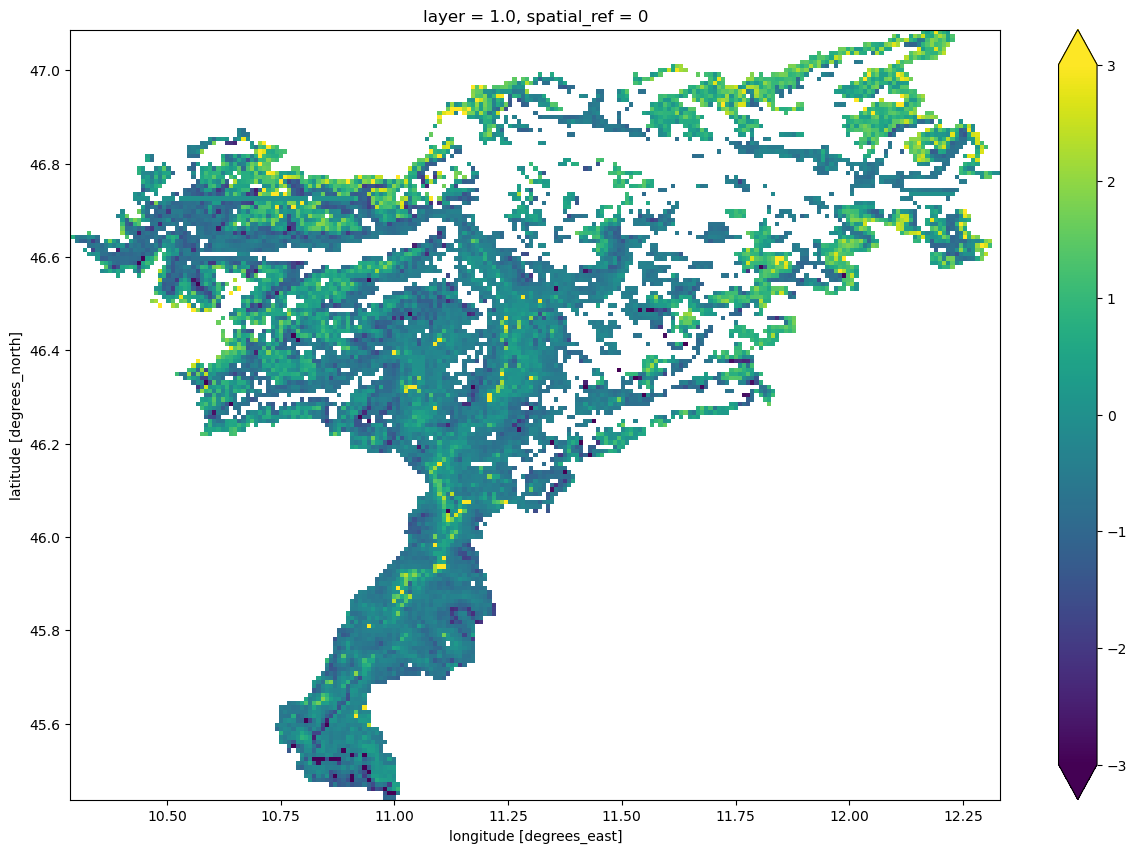

In [201]:
mask = (ds_static < 1000).KsatVer
sens.where(mask).mean("time").plot(figsize=(15,10), vmin=-3,vmax=3)

In [ ]:
ts_compare(grad_static,   grad_static, label_1="grad", label_2 = "sensitivity", lat = [46.5], lon = [11.4]   )

In [ ]:
Y_test = normalizer_target.denormalize(Y_test)

In [ ]:
# === Plotting =============================================================================

from plot_in import prepare_for_in_plotting,ts

dynamic_feature_plot = sensitivity_actevap.detach().reshape(180,223,731,3)
# dynamic_feature_plot = Xd_test.values.reshape(180,223,731,3)

array_no_nan = np.nan_to_num(dynamic_feature_plot, nan=0)

from plot_in import prepare_for_in_plotting,ts_compare_in
coords  = ds_target.sel(time=valid_temporal_range).coords
def to_xr(arr, coords, dims=["lat", "lon", "time"]):
    return xr.DataArray(arr, dims=dims, coords=coords)
yhat = to_xr(array_no_nan[:,:,:,1], coords=coords)
y_target_plot

In [ ]:
# === sensitivity map of dynamic parameters with related to the MSE.
#.     Xd_gradient * Xd_values =============================================================================

sensitivity = Xd_grad1*Xd_test.values


In [ ]:
# === Plotting =============================================================================

from plot_in import prepare_for_in_plotting,ts_compare_in

dynamic_feature_plot = Xd_grad1.detach().reshape(180,223,731,3)
# dynamic_feature_plot = Xd_test.values.reshape(180,223,731,3)

array_no_nan = np.nan_to_num(dynamic_feature_plot, nan=0)

from plot_in import prepare_for_in_plotting,ts_compare_in
coords  = ds_target.sel(time=valid_temporal_range).coords
def to_xr(arr, coords, dims=["lat", "lon", "time"]):
    return xr.DataArray(arr, dims=dims, coords=coords)
yhat = to_xr(array_no_nan[:,:,:,1], coords=coords)

ts_compare_in(yhat,lat = [46.4], lon = [11.4])

